In [20]:
import numpy as np 
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

Daten einlesen

In [21]:
ds_0D = pd.read_csv("input/0D.csv", sep=',')
ds_0E = pd.read_csv("input/0E.csv", sep=',')
ds_1D = pd.read_csv("input/1D.csv", sep=',')
ds_1E = pd.read_csv("input/1E.csv", sep=',')
ds_2D = pd.read_csv("input/2D.csv", sep=',')
ds_2E = pd.read_csv("input/2E.csv", sep=',')
ds_3D = pd.read_csv("input/3D.csv", sep=',')
ds_3E = pd.read_csv("input/3E.csv", sep=',')
ds_4D = pd.read_csv("input/4D.csv", sep=',')
ds_4E = pd.read_csv("input/4E.csv", sep=',')

In [22]:
#Dictonary erstellen, um einfacher durch die Daten durchzugehen
name_dict = {
    "ds_0D": ds_0D,
    "ds_0E": ds_0E,
    "ds_1D": ds_1D,
    "ds_1E": ds_1E,
    "ds_2D": ds_2D,
    "ds_2E": ds_2E,
    "ds_3D": ds_3D,
    "ds_3E": ds_3E,
    "ds_4D": ds_4D,
    "ds_4E": ds_4E,
}

Alle Daten bei welchem V_in = 0 ist rauswerfen -> Da sind sehr hohe Vibrationsdaten drin welche stören könnten

In [23]:

for name, df in name_dict.items():
    df.drop(df.index[df['V_in'] <= 0], inplace=True) 
    print(f'Name {name}')



Name ds_0D
Name ds_0E
Name ds_1D
Name ds_1E
Name ds_2D
Name ds_2E
Name ds_3D
Name ds_3E
Name ds_4D
Name ds_4E


In [24]:
display(ds_0D.min())
ds_0D.max()

V_in              2.000000
Measured_RPM    618.430820
Vibration_1      -0.106750
Vibration_2      -0.206724
Vibration_3      -0.036530
dtype: float64

V_in              10.000000
Measured_RPM    2376.684900
Vibration_1        1.237924
Vibration_2        2.160684
Vibration_3        1.496519
dtype: float64

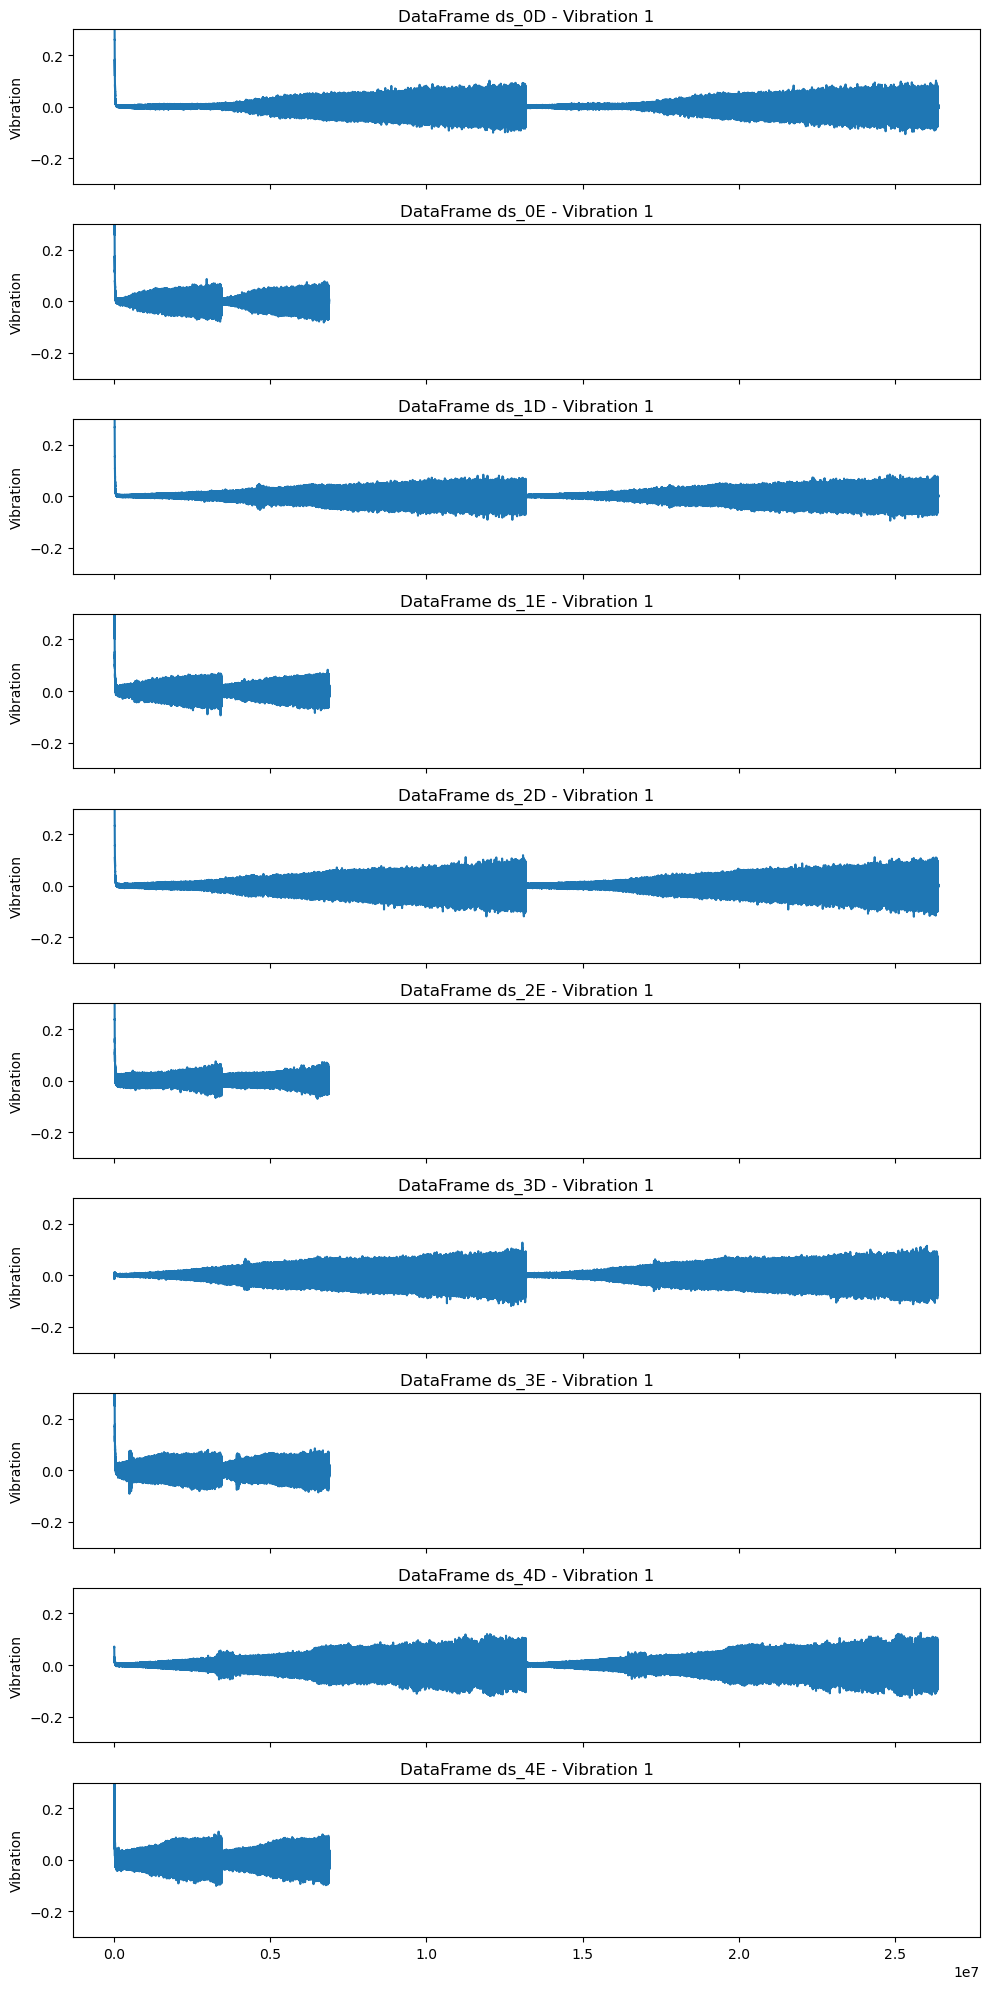

In [25]:

def create_hist(name_dict):
    subplot_counter=len(name_dict)
    fig, axes = plt.subplots(subplot_counter, 1, figsize=(10, subplot_counter * 2), sharex=True)
    for i,(name,df) in enumerate(name_dict.items()):
    # Plot für Vibration_1
        axes[i].plot(range(len(df["Vibration_1"])), df["Vibration_1"])
        axes[i].set_title(f'DataFrame {name} - Vibration 1')
        axes[i].set_ylim(-0.3, 0.3)
        axes[i].set_ylabel("Vibration")

        
        
    plt.tight_layout()
    plt.show()
    
create_hist(name_dict)

In [26]:
ds_0D.head()

,V_in,Measured_RPM,Vibration_1,Vibration_2,Vibration_3
12288,2.0,628.97701,1.237866,2.160670,1.496519
12289,2.0,628.97701,1.237705,2.160413,1.496451
12290,2.0,628.97701,1.237924,2.160684,1.496072
12291,2.0,628.97701,1.237156,2.160023,1.495891
12292,2.0,628.97701,1.236045,2.159494,1.495874


Daten auf eine Samplegröße von 0.01 runter brechen. -> Beim Finalen Training wieder ausnehmen

In [27]:
for name, df in name_dict.items():
    sample_df = df.sample(frac=0.01, random_state=3, ignore_index=0).sort_index()
    #Daten überschreiben im Dict
    name_dict[name] = sample_df
    #Daten des globalen Df überschreiben
    globals()[name] = sample_df
    print(f'Name {name}')
# ds_0D = ds_0D.sample(frac=0.01, random_state=3, ignore_index=1)
# ds_0E = ds_0E.sample(frac=0.01, random_state=3, ignore_index=1)
# ds_1D = ds_1D.sample(frac=0.01, random_state=3, ignore_index=1)
# ds_1E = ds_1E.sample(frac=0.01, random_state=3, ignore_index=1)
# ds_2D = ds_2D.sample(frac=0.01, random_state=3, ignore_index=1)
# ds_2E = ds_2E.sample(frac=0.01, random_state=3, ignore_index=1)
# ds_3D = ds_3D.sample(frac=0.01, random_state=3, ignore_index=1)
# ds_3E = ds_3E.sample(frac=0.01, random_state=3, ignore_index=1)
# ds_4D = ds_4D.sample(frac=0.01, random_state=3, ignore_index=1)
# ds_4E = ds_4E.sample(frac=0.01, random_state=3, ignore_index=1)

Name ds_0D
Name ds_0E
Name ds_1D
Name ds_1E
Name ds_2D
Name ds_2E
Name ds_3D
Name ds_3E
Name ds_4D
Name ds_4E


In [28]:
ds_0D.head()

,V_in,Measured_RPM,Vibration_1,Vibration_2,Vibration_3
12431,2.0,628.97701,1.214155,2.122328,1.468927
12446,2.0,628.97701,1.210674,2.118407,1.466274
12580,2.0,628.97701,1.189539,2.083245,1.441972
12721,2.0,628.97701,1.167654,2.047373,1.416371
12866,2.0,628.97701,1.145290,2.010351,1.390545


In [29]:
display(ds_0D.min())
ds_0D.max()
len(ds_0D)



V_in              2.000000
Measured_RPM    618.430820
Vibration_1      -0.075319
Vibration_2      -0.124464
Vibration_3      -0.027877
dtype: float64

264110

Die dynamische Unwucht der Welle mit einfügen 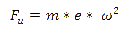 [N]


In [30]:
mass= [0,0.003281,0.003281,0.003281,0.006614] #[kg]
radius = [0,0.014,0.0185,0.023,0.023] #[m]
def unbalance (rpm,i):
    omega = 2 * np.pi * rpm / 60 #Winkelgeschwindigkeit
    unbalance = mass[i]*radius[i]*omega**2
    return unbalance



Weitere Spalte erzeugen, dessen Output im späteren Vorhergesagt werden kann -> Hat der Motor eine Unwucht

In [31]:
ds_0D['UnbalanceForce'] = ds_0D['Measured_RPM'].apply(lambda rpm: unbalance(rpm, 0))
ds_0D['Unbalance'] = False

ds_0E['UnbalanceForce'] = ds_0E['Measured_RPM'].apply(lambda rpm: unbalance(rpm, 0))
ds_0E['Unbalance'] = False

ds_1D['UnbalanceForce'] = ds_1D['Measured_RPM'].apply(lambda rpm: unbalance(rpm, 1))
ds_1D['Unbalance'] = True

ds_1E['UnbalanceForce'] = ds_1E['Measured_RPM'].apply(lambda rpm: unbalance(rpm, 1))
ds_1E['Unbalance'] = True

ds_2D['UnbalanceForce'] = ds_2D['Measured_RPM'].apply(lambda rpm: unbalance(rpm, 2))
ds_2D['Unbalance'] = True

ds_2E['UnbalanceForce'] = ds_2E['Measured_RPM'].apply(lambda rpm: unbalance(rpm, 2))
ds_2E['Unbalance'] = True

ds_3D['UnbalanceForce'] = ds_3D['Measured_RPM'].apply(lambda rpm: unbalance(rpm, 3))
ds_3D['Unbalance'] = True

ds_3E['UnbalanceForce'] = ds_3E['Measured_RPM'].apply(lambda rpm: unbalance(rpm, 3))
ds_3E['Unbalance'] = True

ds_4D['UnbalanceForce'] = ds_4D['Measured_RPM'].apply(lambda rpm: unbalance(rpm, 4))
ds_4D['Unbalance'] = True

ds_4E['UnbalanceForce'] = ds_4E['Measured_RPM'].apply(lambda rpm: unbalance(rpm, 4))
ds_4E['Unbalance'] = True

Daten zusammenführen in Trainings und evaluierungsdaten -> pd.concat

In [33]:
train_data= pd.concat([ds_0D,ds_1D,ds_2D,ds_3D,ds_4D])
eval_data= pd.concat([ds_0E,ds_1E,ds_2E,ds_3E,ds_4E])

Alle Daten mit negativen RPM Werten rausschmeißen


In [34]:
train_data = train_data.drop(train_data.index[train_data['Measured_RPM'] < 0])
eval_data = eval_data.drop(eval_data.index[eval_data['Measured_RPM'] < 0])

In [35]:
train_data.describe()

,V_in,Measured_RPM,Vibration_1,Vibration_2,Vibration_3,UnbalanceForce
count,1.319540e+06,1.319540e+06,1.319540e+06,1.319540e+06,1.319540e+06,1.319540e+06
mean,6.001983e+00,1.480645e+03,9.136955e-04,1.309226e-03,3.250015e-03,1.785269e+00
std,2.323766e+00,4.937063e+02,1.590669e-02,2.881313e-02,1.535166e-02,1.900134e+00
min,2.000000e+00,6.042875e+02,-1.106381e-01,-1.818502e-01,-3.685594e-02,0.000000e+00
25%,4.000000e+00,1.053371e+03,-1.891851e-03,-2.236366e-03,1.451969e-03,3.814261e-01
50%,6.000000e+00,1.478688e+03,6.341934e-04,6.365776e-04,2.889633e-03,1.265558e+00
75%,8.000000e+00,1.905912e+03,3.472567e-03,3.501177e-03,4.523992e-03,2.543503e+00
max,1.000000e+01,4.091723e+03,1.280695e+00,2.178069e+00,1.538677e+00,2.447790e+01


Daten in Histogramm Visualisieren

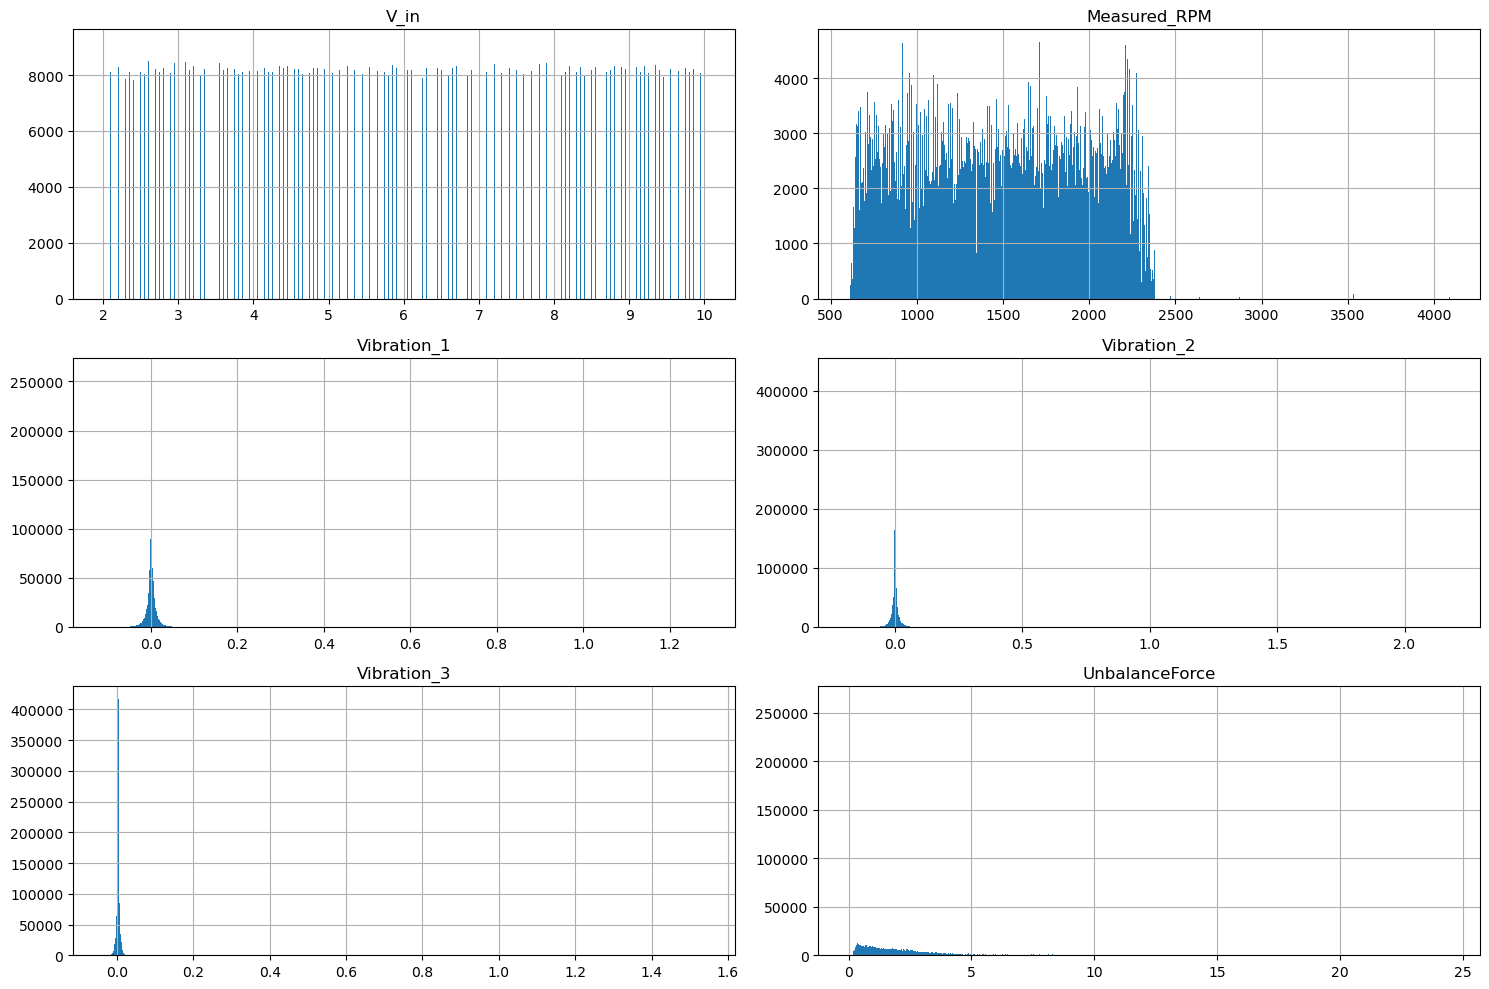

In [36]:
train_data.hist(bins=1000, figsize=(15, 10))
plt.tight_layout()
plt.show()

Boxplots der Daten erstellen

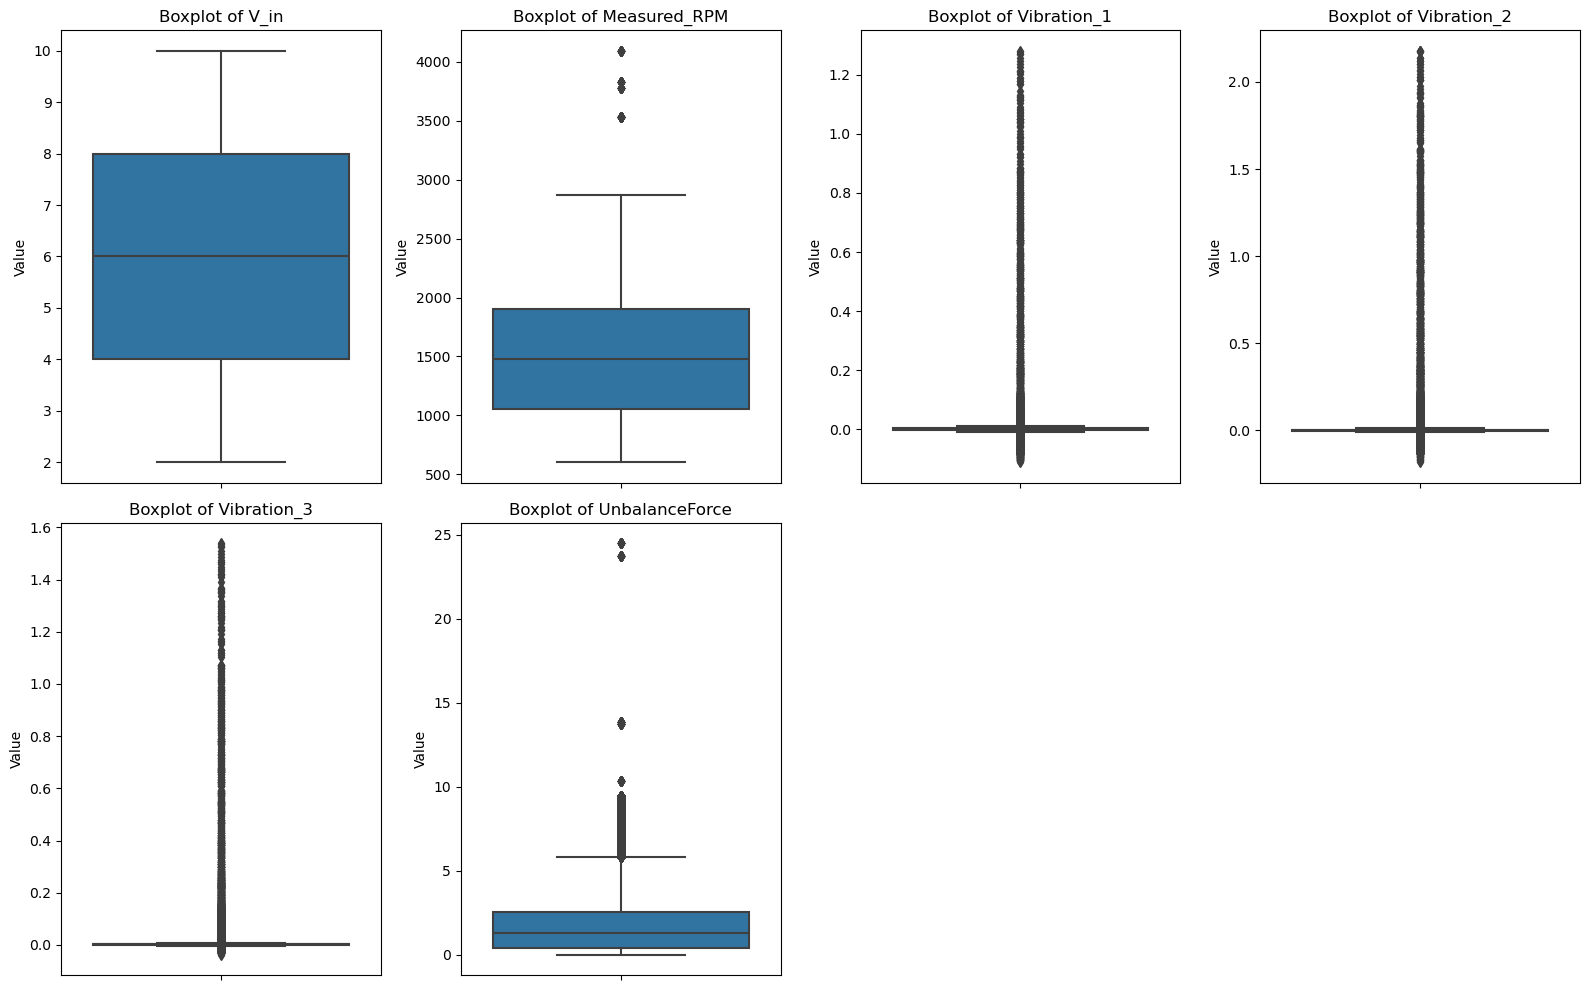

In [37]:
# Bereinigen der Daten (Fehlende Werte durch den Mittelwert ersetzen)
box_plot_data = train_data.fillna(train_data.mean())
# Nur numerische Spalten verwenden
box_plot_data = box_plot_data.select_dtypes(include=[np.number])
# Berechne die Anzahl der Spalten und lege ncols fest
num_columns = len(box_plot_data.columns)
# Bestimme die Anzahl der Spalten und Zeilen im Subplot-Raster
ncols = 4  # Hier definierst du die maximale Anzahl der Boxplots pro Zeile
nrows = (num_columns // ncols) + int(num_columns % ncols != 0)  # Berechnet die benötigte Anzahl an Zeilen
# Erstelle das Subplot-Gitter
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 4, nrows * 5))  # Passe die Gesamtgröße an

# Schleife über die Spalten, um jeweils einen Boxplot zu erstellen
for i, column in enumerate(box_plot_data.columns):
    # Berechne die Position des Subplots
    ax = axes[i // ncols, i % ncols]  # Bestimme die Zeile (i//ncols) und Spalte (i%ncols)

    # Erstelle den Boxplot (mit vertikalem Orientieren)
    sns.boxplot(data=box_plot_data, y=column, ax=ax, orient='v')
    
    # Titel und Achsentitel hinzufügen
    ax.set_title(f"Boxplot of {column}")
    ax.set_ylabel('Value')  # Optional: Beschriftung für die y-Achse

# Entferne leere Achsen, falls vorhanden (falls weniger Spalten als Zeilen x Spalten vorhanden sind)
for i in range(num_columns, nrows * ncols):
    fig.delaxes(axes[i // ncols, i % ncols])

# Layout anpassen und anzeigen
plt.tight_layout()
plt.show()


Korrelationsmatrix der Daten erstellen

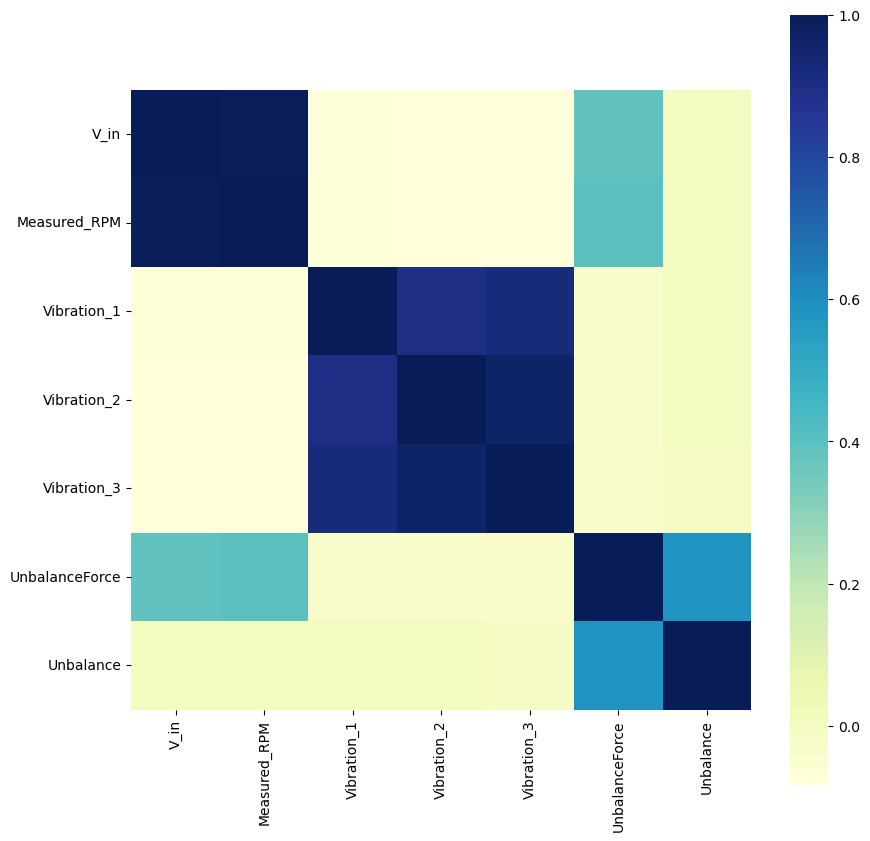

In [38]:
plt.figure(figsize=(10,10))
sns.heatmap(eval_data.corr(numeric_only=True), cmap="YlGnBu", annot=False,square=True)
plt.show()
